### <h2 style="text-align:center;"><strong>How to - SpiDy</strong></h2>
<hr>

### Modules

In [1]:
using SpiDy
using LinearAlgebra
using DifferentialEquations
using FFTW
using Random
using Distributions
using Statistics
using Interpolations
using DSP
using Plots
using StatsBase
using NPZ
using Cubature

### Parameters

In [93]:
Δt = 0.1
N = 10_000
Random.seed!(123); # the exclamation mark here is warning us that we are changing a global property, in this case the random seed

In [137]:
J = LorentzianSD(1., 7., 5.); # LorentzianSD(α, ω0, Γ)

In [120]:
# NB: Double check the cut-off value in the plots of the PSD.
#     For a Ohmic (s=1) spectral density, the PSD should result
#     in a constant function at all frequencies. Try comparison
#     between ωcut=100 or ωcut=10000 just below.
# J = PolySD(1., 2., 100.); # PolySD(s, α, ωcut)
J = PolySD(1., 2., 10000.); # PolySD(s, α, ωcut)

### Noise

In [125]:
noise = ClassicalNoise(1.);

In [126]:
noise = QuantumNoise(0.1);

In [127]:
fpsd = psd(J, noise);
fspectrum = spectrum(noise);

### Distribution

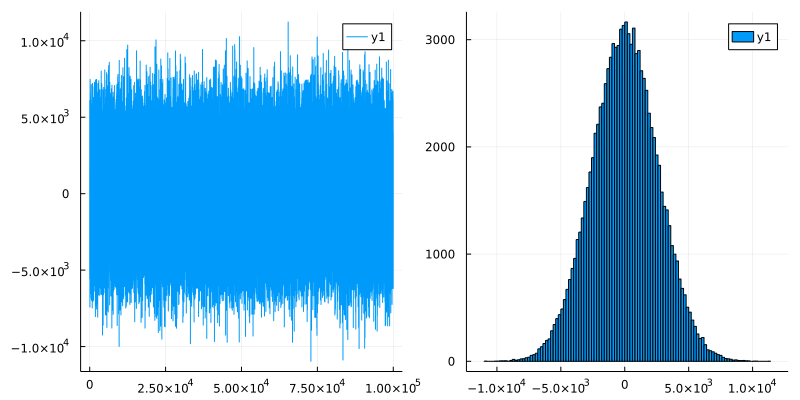

In [122]:
distro=Normal(0., 1/sqrt(Δt)); # This is the model distribution. Now we need to extract values from this distribution.
distrosample = rand(distro, N);
p1 = plot(distrosample);
p2 = histogram(distrosample);
plot(p1, p2; size=(800, 400))

### Stochastic field

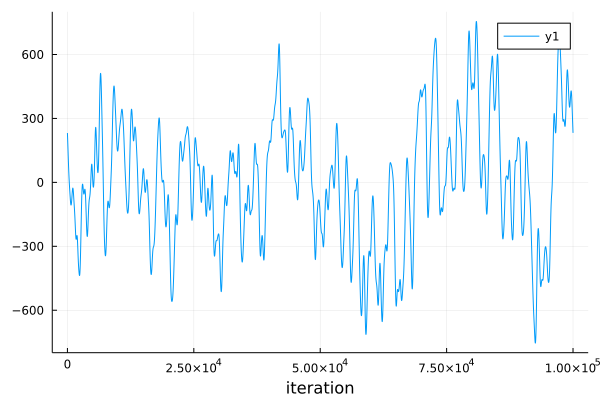

In [123]:
plot(bfield(N, Δt, J, noise; interpolation=false), xlabel="iteration")

### Consistency checks

#### Spectrum, imag(kernel) and psd

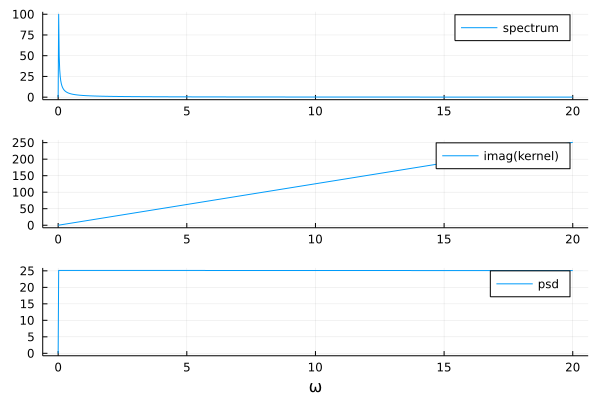

In [124]:
freqrange = LinRange(0, 20, 1000)
atest = spectrum(noise).(freqrange)
btest = imagkernel(J).(freqrange)
p1 = plot(freqrange, atest, label="spectrum");
p2 = plot(freqrange, btest, label="imag(kernel)");
p3 = plot(freqrange, atest.*btest, label="psd", xlabel = "ω")
plot(p1, p2, p3, layout=(3, 1))

#### Compare periodogram of the stochastic field with psd

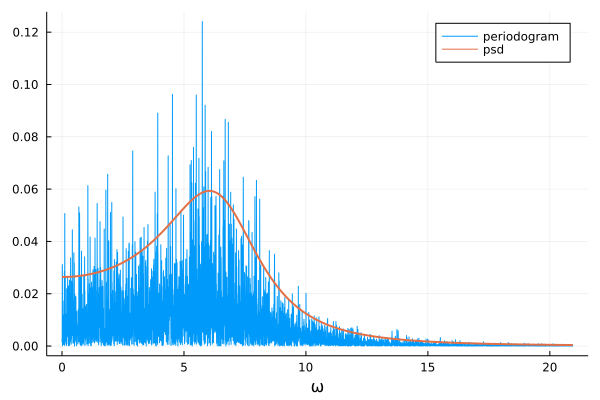

In [9]:
angfreq = 2π*rfftfreq(N, 1/Δt);
b = bfield(N, Δt, J, noise; interpolation=false)
psdperiodogram = periodogram(b, nfft=N, fs=1/Δt)
psdint = hquadrature(fpsd, angfreq[1], angfreq[end])[1]

plot(2π*freq(psdperiodogram), power(psdperiodogram), xlabel = "ω", label="periodogram")
plot!(angfreq, fpsd.(angfreq)/psdint*var(b)*20, lw=2, label="psd")

# The computed periodogram is normalized so that the area under the periodogram is
# equal to the uncentered variance (or average power) of the original signal

#### Compare histogram of the stochastic field with analytical variance

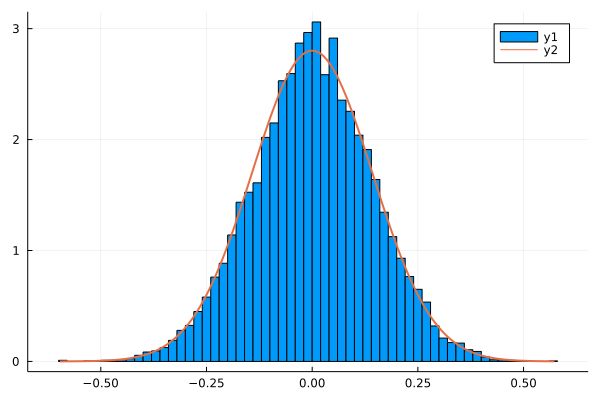

In [8]:
angfreq = 2π*rfftfreq(N, 1/Δt);
bvalues = bfield(N, Δt, J, noise; interpolation=false)

sigma = sqrt(2*hquadrature(fpsd, angfreq[1], angfreq[end])[1]/2π) # multiplied by 2 because the psd is performed only for positive omegas!!
gauss = x -> pdf(Normal(0.0, sigma), x)

xvals = LinRange(minimum(bvalues), maximum(bvalues), 1000)
histogram(bvalues, bins=100, normalize=true)
plot!(xvals, gauss.(xvals), lw=2)

### Coupling tensor

In [17]:
matrix = IsoCoupling(2.);
matrix.C

2.0

In [18]:
matrix = AnisoCoupling([-sin(π/4) 0. 0.
                        0. 0. 0.
                        cos(π/4) 0. 0.]);
matrix.C

3×3 Matrix{Float64}:
 -0.707107  0.0  0.0
  0.0       0.0  0.0
  0.707107  0.0  0.0

### Dynamics

In [20]:
tspan = (0., N*Δt)
saveat = (0:1:N)*Δt
noise = ClassicalNoise(1.);
s0 = [0., 0., -1.]
bfields = [bfield(N, Δt, J, noise),
           bfield(N, Δt, J, noise),
           bfield(N, Δt, J, noise)];

sol = diffeqsolver(s0, tspan, J, bfields, matrix; saveat=saveat);

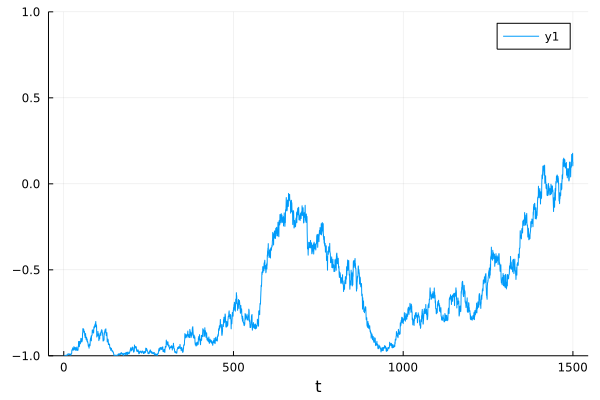

In [21]:
plot(sol[1], sol[2][:, 3], ylim=(-1,1), xlabel="t")

### Dynamics averaged

In [22]:
tspan = (0., N*Δt)
saveat = (0:1:N)*Δt
noise = ClassicalNoise(1.);
s0 = [0., 0., -1.]

navg = 2

sols = zeros(navg, length(saveat), 3)
for i in 1:navg
    bfields = [bfield(N, Δt, J, noise),
               bfield(N, Δt, J, noise),
               bfield(N, Δt, J, noise)];
    sol = diffeqsolver(s0, tspan, J, bfields, matrix; saveat=saveat);
    sols[i, :, :] = sol[2]
end
solavg = mean(sols, dims=1)[1, :, :];

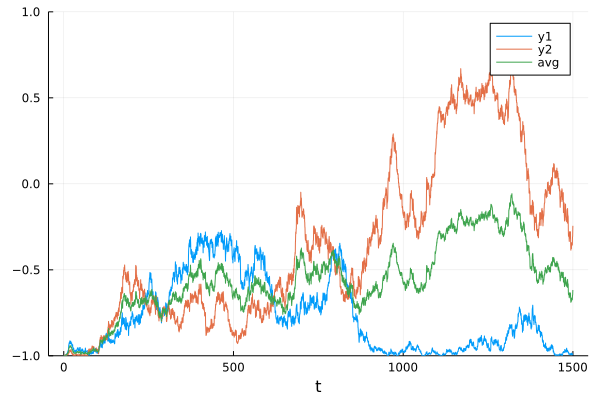

In [23]:
plot(saveat, sols[1, :, 3])
plot!(saveat, sols[2, :, 3])
plot!(saveat, solavg[:, 3], label="avg", ylim=(-1, 1), xlabel="t")

### Steady-state

In [24]:
tspan = (0., N*Δt)
saveat = ((N*4÷5):1:N)*Δt # NB: now, we save only the late-time dynamics to evaluate the steady-state value
noise = ClassicalNoise(1.);
s0 = normalize(rand(3))
bfields = [bfield(N, Δt, J, noise),
           bfield(N, Δt, J, noise),
           bfield(N, Δt, J, noise)];

sol = diffeqsolver(s0, tspan, J, bfields, matrix; saveat=saveat);

s = mean(sol[2], dims=1);

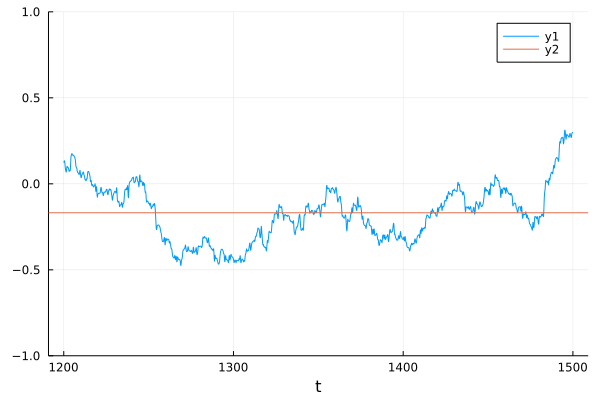

In [25]:
plot(sol[1], sol[2][:, 3], ylim=(-1,1), xlabel="t")
hline!([s[3]])

### Steady-state averaged

In [35]:
tspan = (0., N*Δt)
saveat = ((N*4÷5):1:N)*Δt # NB: now, we save only the late-time dynamics to evaluate the steady-state value

T = 10 .^ LinRange(-3, 3, 12) # range of temperatures where to evaluate the noise
navg = 10 # number of stochastic field realizations to average

Sss = zeros(length(T), 3)
for n in 1:length(T)
    noise = ClassicalNoise(T[n]);
    s = zeros(navg, 3)
    for i in 1:navg
        s0 = [0., 0., -1.]
        bfields = [bfield(N, Δt, J, noise),
                   bfield(N, Δt, J, noise),
                   bfield(N, Δt, J, noise)];
        sol = diffeqsolver(s0, tspan, J, bfields, matrix; saveat=saveat);
        s[i, :] = mean(sol[2], dims=1)
    end
    Sss[n, :] = mean(s, dims=1)
end

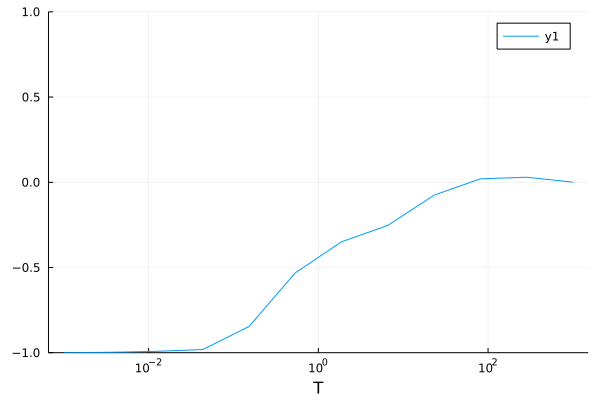

In [37]:
plot(T, Sss[:, 3], xscale=:log10, ylim=(-1, 1), xlabel="T")

### <h2 style="text-align:center"><strong>But this is how the code should be run</strong></h2>

Visit https://github.com/quantum-exeter/SpiDy.jl and follow the readme for instructions on the installation.

To run the code,
* save <a href=https://raw.githubusercontent.com/quantum-exeter/SpiDy.jl/main/runs/run_dynamics.jl>run_dynamics.jl</a> or <a href=https://raw.githubusercontent.com/quantum-exeter/SpiDy.jl/main/runs/run_steadystate.jl>run_steadystate.jl</a> in your preferred location (open the link -> right click on the page -> save as... should work to save the file)
* open the terminal or command line
* run the following command,
```Julia
julia "path-to-your-file"/run_dynamics.jl
```
where "path-to-your-file" is the one where you saved your file. Replace *run_dynamics.jl* with *run_steadystate.jl* to run the one of your choice.

**This last command will run the code and save plots/datafile of the chosen run. CONGRATS, you have just run SpiDy for the first time!**

NB: the code can exploit parallel computation. To do this, run your files as
```Julia
julia -t 6 "path-to-your-file"/run_dynamics.jl
```
where you want to replace "6" with the number of threads you wish to use. As a general tip, you do not want to use more than 80% of the number of threads you have available in your machine, e.g. if you have a 4-core CPU, you are likely to have 8 threads and you may want to run the parallelization as indicated above.

<h2 style="text-align:center"><strong>ENJOY!</strong></h2>